# Finsearch 2025 midterm Submission

This is the Code for the Midterm report submission of the Finsearch 2025.

Topic - Use deep reinforcement learning (RL) to optimise stock trading
strategy and thus maximise investment return.

Starting of with importing libraries for RL model. Gymnaisum is used to create a environment for inverted pendulum.

Pytorch and its nn library is used to build the neural networks which is the key factor in building the DQN model.



In [76]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import random
from collections import deque
import matplotlib.pyplot as plt


Followed by implemenntation of noise known as  Ornstein-Uhlenbeck noise. It is 

In [77]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)



Now let us create a environment in the using the gymnasium library for the inverted pendulum.

We have defined the state size, the possible action which the discrete action which can be performed through linspace.

In [78]:
env = gym.make("Pendulum-v1")
state_size = env.observation_space.shape[0]
action_low, action_high = env.action_space.low[0], env.action_space.high[0]

# Discretize action space
num_discrete_actions = 11
discrete_actions = np.linspace(action_low, action_high, num_discrete_actions)

# OU noise (used here as optional additive noise to selected action)
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=0.2 * np.ones(1))

This shows the state of the pedulum and max and min values for the action.
Note that the action here is not discrete and can vary continuously from -2 to +2.
Along with that we also have the set of all the possible actions.

Now let us note down the parameters for the DQN model.
We will update all these parameters through RL these are just the intialization of the parameters.

In [79]:
# 2. DQN parameters
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
learning_rate = 0.001
episodes = 300
max_steps = 200
batch_size = 64
replay_buffer = deque(maxlen=500)
target_update_freq = 10

Now defining the DQN model for the inverted pendulum.

I have used TensorFlows keras library to build this model. It contains 3 layers of neutral network along with Relu is the Activation method as it the most appropriate method for the given model.RELU is used as the squish the output unlike the sigmoid or tanh.

I have used Adam optimizer for the model as it keeps track of the Momentum that is keeps track of the past gradients and also adapts the learning rate according to the parameters.

We have then modified the weight through the backpropagation.

In [80]:
def build_q_network():
    model = tf.keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(state_size,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_discrete_actions, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
    return model

In [81]:
model = build_q_network()
target_model = build_q_network()
target_model.set_weights(model.get_weights())

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Here we have defined the Epsilon greedy policy which is essential for Exploration and Exploitation.

In this case if the random value is greater than epsilon then only it will predict the q_value which is Explotation.
While if its less then it will Exploration by givening the random value between the action range.

The value of epsilon was defined earlier in the parameters.

In [82]:
def select_action(state, use_noise=True):
    if np.random.rand() < epsilon:
        return random.randint(0, num_discrete_actions - 1)
    q_values = model.predict(np.array([state]), verbose=0)[0]
    return np.argmax(q_values)

Now let us train our model with the given data.

Here I have replay function which is used to update the value of the state and target vector by predicting it through the model defined. It will continue if we achieve maximum reward or the length of buffer exceed batch size.

In [83]:
def replay():
    if len(replay_buffer) < batch_size:
        return

    minibatch = random.sample(replay_buffer, batch_size)
    states, targets = [], []

    for state, action_idx, reward, next_state, done in minibatch:
        target = model.predict(np.array([state]), verbose=0)[0]
        if done:
            target[action_idx] = reward
        else:
            future_q = target_model.predict(np.array([next_state]), verbose=0)[0]
            target[action_idx] = reward + gamma * np.amax(future_q)
        states.append(state)
        targets.append(target)

    model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)


Here we have defined the training loop where in we are define a episode and included the rewards generate in the list of rewards_per_episode.

We have set the state and reward in each step to analyse the action and then adding it to the buffer. Based on the model we are updating the state and action. According we are modfing the epsilon according to the reward.

Ulimate goal is to maximise the reward which we can see through the values we are optaining after each episode.

In [84]:
rewards_per_episode = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for step in range(max_steps):  # Make sure this loop breaks!
        action_idx = select_action(state)
        action = [discrete_actions[action_idx]]
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        buffer.append((state, action_idx, reward, next_state, done))
        state = next_state
        total_reward += reward

        replay()  # Train the model

        if done:
            break

    rewards_per_episode.append(total_reward)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target model
    if ep % target_update_freq == 0:
        target_model.set_weights(model.get_weights())

    print(f"Episode {ep+1}/{episodes} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.2f}")


Episode 1/300 | Reward: -1151.10 | Epsilon: 0.99
Episode 2/300 | Reward: -967.38 | Epsilon: 0.99
Episode 3/300 | Reward: -1733.75 | Epsilon: 0.99
Episode 4/300 | Reward: -1055.10 | Epsilon: 0.98
Episode 5/300 | Reward: -1110.10 | Epsilon: 0.98
Episode 6/300 | Reward: -1597.31 | Epsilon: 0.97
Episode 7/300 | Reward: -1066.29 | Epsilon: 0.97
Episode 8/300 | Reward: -1189.15 | Epsilon: 0.96
Episode 9/300 | Reward: -1075.65 | Epsilon: 0.96
Episode 10/300 | Reward: -994.33 | Epsilon: 0.95
Episode 11/300 | Reward: -1078.51 | Epsilon: 0.95
Episode 12/300 | Reward: -1388.02 | Epsilon: 0.94
Episode 13/300 | Reward: -1243.67 | Epsilon: 0.94
Episode 14/300 | Reward: -968.68 | Epsilon: 0.93
Episode 15/300 | Reward: -1461.45 | Epsilon: 0.93
Episode 16/300 | Reward: -915.29 | Epsilon: 0.92
Episode 17/300 | Reward: -1616.71 | Epsilon: 0.92
Episode 18/300 | Reward: -1388.24 | Epsilon: 0.91
Episode 19/300 | Reward: -1331.72 | Epsilon: 0.91
Episode 20/300 | Reward: -1671.52 | Epsilon: 0.90
Episode 21/30

Now let us try to visualise the trained pendulum by ploting it using the matplotlib library.

Let us see it works after we train the RL model.

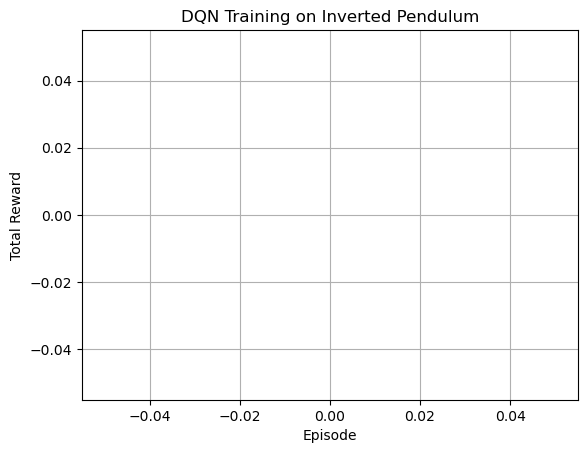

In [87]:
# 8. Plot rewards
plt.plot(rewards_per_episode)
plt.title("DQN Training on Inverted Pendulum")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()